#### Library import

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [42]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [43]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [44]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13993667785251102745
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13915413524744904234
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [45]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [46]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [47]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [48]:
As = data
Cd = data
Ni = data

In [49]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [50]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Eliminate outlier and train / test split

In [51]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [52]:
As = eli_outlier(As, "As")
Cd = eli_outlier(Cd, "Cd")
Ni = eli_outlier(Ni, "Ni")

In [53]:
As_X = As.drop(["As"], axis=1)
Cd_X = Cd.drop(["Cd"], axis=1)
Ni_X = Ni.drop(["Ni"], axis=1)

As_y = As["As"]
Cd_y = Cd["Cd"]
Ni_y = Ni["Ni"]

In [54]:
As_y = np.log1p(As["As"])
Cd_y = np.log1p(Cd["Cd"])
Ni_y = np.log1p(Ni["Ni"])

In [55]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1288, 15)
(1271, 15)
(1424, 15)


StandardScaler

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [57]:
As_train_re_X = pd.DataFrame(As_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

Cd_train_re_X = pd.DataFrame(Cd_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

Ni_train_re_X = pd.DataFrame(Ni_X_train, columns = ['pH','slope','altitude','profile_curve','planform_curve',
                                               'HYDGRP_A','HYDGRP_B','HYDGRP_C','HYDGRP_D','SOL_K1','CLAY1','SILT1','SAND1','ROCK1','distance'])

In [58]:
As_y_train = As_y_train.reset_index(drop = True)
Cd_y_train = Cd_y_train.reset_index(drop = True)
Ni_y_train = Ni_y_train.reset_index(drop = True)

In [59]:
As_train_re = pd.concat([As_train_re_X, As_y_train], axis=1)
Cd_train_re = pd.concat([Cd_train_re_X, Cd_y_train], axis=1)
Ni_train_re = pd.concat([Ni_train_re_X, Ni_y_train], axis=1)

#### Oversampling by SMOGN (SMOTE Regression)

In [60]:
import smogn

In [61]:
As_smogn = smogn.smoter(data = As_train_re, y = 'As', samp_method = 'extreme', rel_coef = 0.50)
Cd_smogn = smogn.smoter(data = Cd_train_re, y = 'Cd', samp_method = 'extreme', rel_coef = 0.50)
Ni_smogn = smogn.smoter(data = Ni_train_re, y = 'Ni', samp_method = 'extreme', rel_coef = 0.50)

dist_matrix:   1%|          | 2/248 [00:00<00:19, 12.74it/s]

r_index: 100%|##########| 188/188 [00:00<00:00, 601.45it/s]


In [62]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1045, 16)
(1137, 16)
(1529, 16)


In [63]:
As_y_train = As_smogn['As']
Cd_y_train = Cd_smogn['Cd']
Ni_y_train = Ni_smogn['Ni']

As_X_train = As_smogn.drop(['As'], axis = 1)
Cd_X_train = Cd_smogn.drop(['Cd'], axis = 1)
Ni_X_train = Ni_smogn.drop(['Ni'], axis = 1)

As_X_train = As_X_train.to_numpy()
Cd_X_train = Cd_X_train.to_numpy()
Ni_X_train = Ni_X_train.to_numpy()

In [64]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [65]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [66]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1045, 15)
(1137, 15)
(1529, 15)


#### 10-Fold Crossvalidation

In [67]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [68]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [69]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [70]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 01:01:51,512] A new study created in memory with name: rf_parameter_opt
[I 2023-08-29 01:01:53,247] Trial 0 finished with value: 0.1334686199806311 and parameters: {'n_estimators': 66, 'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 5}. Best is trial 0 with value: 0.1334686199806311.
[I 2023-08-29 01:01:53,788] Trial 1 finished with value: 0.0719981376899091 and parameters: {'n_estimators': 45, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.1334686199806311.
[I 2023-08-29 01:01:53,892] Trial 2 finished with value: 0.03645501213842637 and parameters: {'n_estimators': 11, 'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 12}. Best is trial 0 with value: 0.1334686199806311.
[I 2023-08-29 01:01:57,563] Trial 3 finished with value: 0.1824163876514266 and parameters: {'n_estimators': 99, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}. Best is trial 3 with value: 0.1824163876514266.
[I 2023-0

Best r2:  0.18702275892851156
Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 7}


In [71]:
optuna.visualization.plot_parallel_coordinate(study)

In [72]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 7}


In [73]:
study.best_trial.params["n_estimators"]

97

In [74]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=97, random_state=42)

In [75]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [76]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [77]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.27352619589242744
Test RMSE:  0.35079393024332656


In [78]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6369086622938962
Test R2:  0.13310083340789547


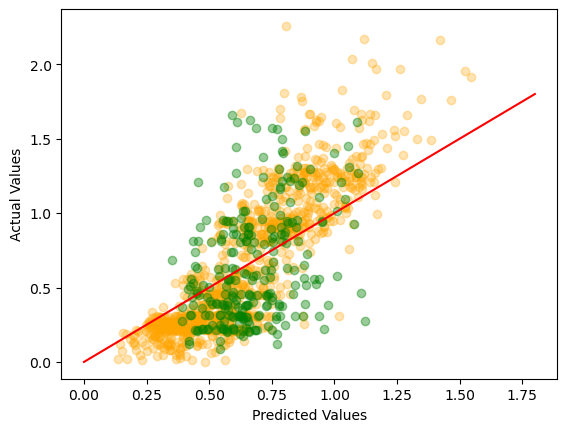

In [79]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [80]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 01:05:51,725] A new study created in memory with name: rf_parameter_opt
[I 2023-08-29 01:05:52,718] Trial 0 finished with value: 0.1314251355964492 and parameters: {'n_estimators': 32, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 0 with value: 0.1314251355964492.
[I 2023-08-29 01:05:53,808] Trial 1 finished with value: 0.0398751299405629 and parameters: {'n_estimators': 86, 'max_depth': 2, 'min_samples_leaf': 11, 'min_samples_split': 14}. Best is trial 0 with value: 0.1314251355964492.
[I 2023-08-29 01:05:54,574] Trial 2 finished with value: 0.06303605158939292 and parameters: {'n_estimators': 48, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.1314251355964492.
[I 2023-08-29 01:05:56,736] Trial 3 finished with value: 0.16014123436784397 and parameters: {'n_estimators': 65, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 14}. Best is trial 3 with value: 0.16014123436784397.
[I 2023

Best r2:  0.19353831600262864
Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [81]:
optuna.visualization.plot_parallel_coordinate(study)

In [82]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


97

In [83]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=97,
                      random_state=42)

In [84]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [85]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.041498487211893385
Test RMSE:  0.055835591616563526


In [86]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.6580319441482898
Test R2:  0.01792071027687514


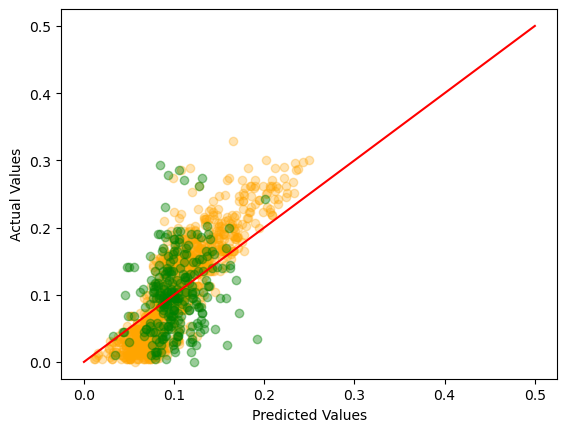

In [87]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [88]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 01:10:03,438] A new study created in memory with name: rf_parameter_opt
[I 2023-08-29 01:10:05,095] Trial 0 finished with value: 0.6180832888791709 and parameters: {'n_estimators': 56, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 19}. Best is trial 0 with value: 0.6180832888791709.
[I 2023-08-29 01:10:06,324] Trial 1 finished with value: 0.5862036157905788 and parameters: {'n_estimators': 44, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 5}. Best is trial 0 with value: 0.6180832888791709.
[I 2023-08-29 01:10:08,990] Trial 2 finished with value: 0.6279499046763062 and parameters: {'n_estimators': 88, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5}. Best is trial 2 with value: 0.6279499046763062.
[I 2023-08-29 01:10:10,388] Trial 3 finished with value: 0.545165430324005 and parameters: {'n_estimators': 62, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 3}. Best is trial 2 with value: 0.6279499046763062.
[I 2023-08-29

Best r2:  0.7242424495672177
Best trial: {'n_estimators': 51, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [89]:
optuna.visualization.plot_parallel_coordinate(study)

In [90]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 51, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


51

In [91]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=51,
                      random_state=42)

In [92]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [93]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.3676225535369196
Test RMSE:  0.7854686668926102


In [94]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.8994234813812668
Test R2:  0.5100235188566873


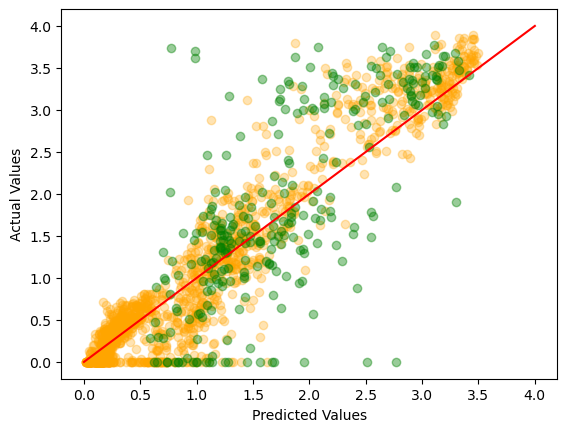

In [95]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()